In [1]:
%matplotlib inline
import sys
import random
sys.path.insert(0, 'datasets/medical/siim-acr-pneumothorax-segmentation/input')

import pandas as pd
import sys
import csv
from PIL import Image
import cv2

from fastai import *
from fastai.vision import *
from model_utils import *
from mask_functions import rle2mask
from fastai.callbacks.hooks import num_features_model

1.0.54


In [2]:
TRAIN_PATH = "/media/disk6tb/datasets/medical/siim-acr-pneumothorax-segmentation/resized/128/train/"
#LABEL_PATH = "/home/sairahul/myfiles/durga/dataset/overlap_masks_new.csv"
LABEL_PATH = "/home/sairahul/myfiles/durga/dataset/newdataset.csv"
RAW_MASKS = "/home/sairahul/myfiles/durga/dataset/train-rle.csv"

df = pd.read_csv(LABEL_PATH)
df.head(10)

,image1,image2,label
0,1.2.276.0.7230010.3.1.4.8323329.1117.151787516...,1.2.276.0.7230010.3.1.4.8323329.14322.15178752...,0
1,1.2.276.0.7230010.3.1.4.8323329.2813.151787517...,1.2.276.0.7230010.3.1.4.8323329.2545.151787517...,0
2,1.2.276.0.7230010.3.1.4.8323329.5795.151787519...,1.2.276.0.7230010.3.1.4.8323329.11602.15178752...,1
3,1.2.276.0.7230010.3.1.4.8323329.5317.151787518...,1.2.276.0.7230010.3.1.4.8323329.500.1517875163...,1
4,1.2.276.0.7230010.3.1.4.8323329.14437.15178752...,1.2.276.0.7230010.3.1.4.8323329.2087.151787517...,0
5,1.2.276.0.7230010.3.1.4.8323329.12154.15178752...,1.2.276.0.7230010.3.1.4.8323329.3978.151787518...,0
6,1.2.276.0.7230010.3.1.4.8323329.10679.15178752...,1.2.276.0.7230010.3.1.4.8323329.367.1517875162...,1
7,1.2.276.0.7230010.3.1.4.8323329.32128.15178751...,1.2.276.0.7230010.3.1.4.8323329.14524.15178752...,1
8,1.2.276.0.7230010.3.1.4.8323329.5610.151787518...,1.2.276.0.7230010.3.1.4.8323329.11007.15178752...,0
9,1.2.276.0.7230010.3.1.4.8323329.10836.15178752...,1.2.276.0.7230010.3.1.4.8323329.12527.15178752...,1


In [3]:
PAIRS = defaultdict(list)
PAIRS_LABEL = {}
for index, row in df.iterrows():
    PAIRS[row['image1']].append([row['image2'], row['label']])
    PAIRS_LABEL[(row['image1'], row['image2'])] = row['label']
    
LABELS = {}
ID_TO_MASK = {}
with open(RAW_MASKS, "r") as fp:
    reader = csv.reader(fp)
    header = next(reader)
    for _id, mask in reader:
        mask = mask.strip()
        _id = _id.strip()
        ID_TO_MASK[_id] = mask
        if mask == "-1":
            LABELS[_id] = 0
            continue
        LABELS[_id] = 1
        

In [4]:
PAIRS['1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090']

[['1.2.276.0.7230010.3.1.4.8323329.14064.1517875249.454414', 1],
 ['1.2.276.0.7230010.3.1.4.8323329.2917.1517875175.358227', 1],
 ['1.2.276.0.7230010.3.1.4.8323329.14472.1517875252.280109', 1]]

In [5]:
# Refer: Pneumothorax%20data%20repack%20and%20image%20statistics.ipynb . Used 128px image stats
mean, std = torch.tensor(([0.6149, 0.6149, 0.6149], [0.2944, 0.2944, 0.2944]))
class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

In [6]:
class SiamImageList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList

    def __len__(self)->int: return len(self.items) or 1 

    def get(self, i):
        fn = self.items[i]
        fn1, fn2 = self.items[i]
        img1 = super().open(fn1)
        img2 = super().open(fn2)
        return SiamImage(img1, img2)

    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        
    @classmethod
    def from_folder(cls, path):
        items = []
        for file in path.glob("*"):
            _id = file.name.rsplit('.', 1)[0]
            for img, label in PAIRS[_id]:
                related_img = file.parent.joinpath(f"{img}.png")
                assert(related_img.is_file())
                items.append([file, related_img])

        return cls(items)
#siam = SiamImageList.from_folder(path=Path(TRAIN_PATH))    

from fastai.vision import learner

class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet50, lin_ftrs=[256, 128], emb_sz=128, ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        #self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        #self.head = learner.create_head(num_features_model(self.body), self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        #self.cnn = nn.Sequential(self.body, self.head)
        self.cnn = create_cnn_model(self.arch, emb_sz, cut=None, pretrained=True, lin_ftrs=lin_ftrs, ps=self.ps, bn_final=self.bn_final)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [7]:
# https://github.com/adambielski/siamese-triplet/blob/master/losses.py
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=23.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        #dist = F.pairwise_distance(op1, op2)
        dist = (op2 - op1).pow(2).sum(1)
        #pdist = dist*target
        #ndist = dist*(1-target)
        #loss = 0.5 * ((pdist**2) + (F.relu(self.margin-ndist)**2))
        losses = 0.5 * (target.float() * dist +
                (1 + -1 * target).float() * F.relu(self.margin - (dist + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [8]:
def gen_label(imgs):
    img1 = imgs[0].name.rsplit('.', 1)[0]
    img2 = imgs[1].name.rsplit('.', 1)[0]
    return float(PAIRS_LABEL[(img1, img2)])

In [9]:
#data = (SiamImageList.from_folder(path=Path(TRAIN_PATH))
#                    .split_by_rand_pct()
#                    .label_from_func(gen_label, label_cls=FloatList)
#                    .databunch(bs=384))

In [10]:
data = (SiamImageList.from_folder(path=Path(TRAIN_PATH))
                    .split_by_rand_pct()
                    .label_from_func(gen_label, label_cls=FloatList)
                    .transform(tfms=get_transforms())
                    .databunch(bs=160))

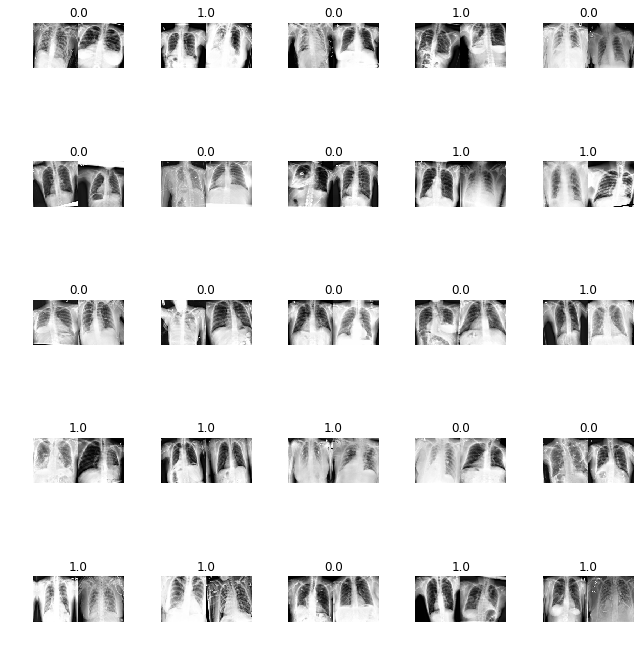

In [11]:
data.show_batch(5)

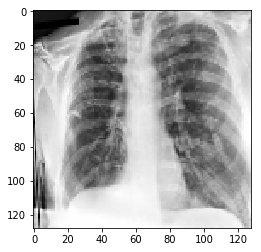

In [12]:
x = next(iter(data.train_dl))
t=x[0][0][0].cpu()
to = mean[...,None,None] + t* std[...,None,None]
import torchvision
ti = torchvision.transforms.ToPILImage(to)
plt.imshow(to.numpy().transpose(1,2,0))

In [13]:
def accuracy_overall(preds, targs, thresh=0.5):
    pair_dist = (F.pairwise_distance(preds[0], preds[1]) < thresh).float()
    return  targs.eq(pair_dist).cpu().sum().float() / len(targs)        

def precision_overall(preds, targs, thresh=0.5, epsilon=1e-8):
    pair_dist = F.pairwise_distance(preds[0], preds[1])
    preds_pos = pair_dist < thresh
    true_pos = torch.mul(preds_pos == targs.byte(), targs.byte())
    return true_pos.sum() / (preds_pos.float().sum() + epsilon)

def recall_overall(preds, targs, thresh=0.5, epsilon=1e-8):
    pair_dist = F.pairwise_distance(preds[0], preds[1])
    preds_pos = pair_dist < thresh
    true_pos = torch.mul(preds_pos == targs.byte(), targs.byte())
    return true_pos.sum() / (targs.sum() + epsilon)

In [14]:
def get_learner():
    model = SiameseNet().cuda()
    apply_init(model.cnn[1], nn.init.kaiming_normal_)
    loss_func=ContrastiveLoss().cuda()
    siam_learner = Learner(data, model, loss_func=loss_func, model_dir=Path(os.getcwd()), layer_groups=[model.cnn[0], model.cnn[1]], opt_func=optim.SGD)
    accuracy_3 = partial(accuracy_overall, thresh=1)
    accuracy_5 = partial(accuracy_overall, thresh=2)
    precision_3 = partial(precision_overall, thresh=1)
    precision_5 = partial(precision_overall, thresh=2)
    recall_3 = partial(recall_overall, thresh=1)
    recall_5 = partial(recall_overall, thresh=2)
    siam_learner.metrics=[accuracy_3, accuracy_5, precision_3, precision_5, recall_3, recall_5] 
    return siam_learner
siam_learner = get_learner()

In [15]:
siam_learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


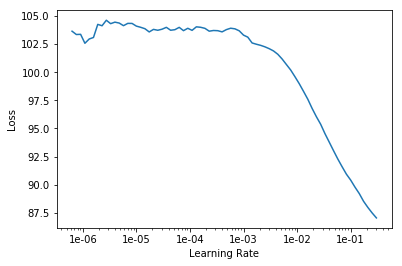

In [16]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [17]:
#siam_learner.fit_one_cycle(20, slice(1*1e-2), div_factor=30., pct_start=0.9, moms=(0.95, 0.85))
#siam_learner.fit_one_cycle(10, 1e-1, div_factor=30., pct_start=0.9, moms=(0.95, 0.85))
siam_learner.fit_one_cycle(10, 2e-2)

epoch,train_loss,valid_loss,accuracy_overall,accuracy_overall,precision_overall,precision_overall,recall_overall,recall_overall,time
0,63.766254,79.121437,0.398080,0.405960,0.000000,0.662735,0.000000,0.020944,04:52
1,63.813961,75.090851,0.398440,0.410040,0.051200,0.702664,0.000591,0.032750,04:51
2,64.199219,68.811836,0.398080,0.400760,0.000000,0.435200,0.000000,0.006131,04:51
3,64.363716,73.589920,0.398760,0.418880,0.156800,0.722127,0.001821,0.056154,04:51
4,64.009781,69.065689,0.405400,0.439200,0.707200,0.782046,0.015631,0.095668,04:52
5,64.434891,75.525810,0.401240,0.431960,0.468800,0.754491,0.008248,0.083082,04:52
6,63.815132,71.280518,0.409000,0.434720,0.737813,0.791863,0.023367,0.082396,04:52
7,63.502613,73.627953,0.409840,0.454240,0.758408,0.767479,0.026564,0.134218,04:51
8,63.221725,73.860062,0.409760,0.452520,0.770240,0.755991,0.026787,0.133678,04:51
9,63.447533,73.514954,0.409360,0.449560,0.755596,0.760641,0.025970,0.125750,04:51


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


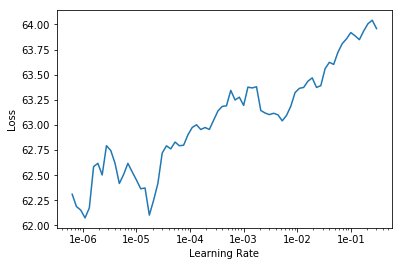

In [18]:
siam_learner.unfreeze()
siam_learner.lr_find()
siam_learner.recorder.plot()

In [19]:
#siam_learner.fit_one_cycle(10, 1e-2, div_factor=20., pct_start=0.7, moms=(0.95, 0.85))
siam_learner.fit_one_cycle(10, 1e-5)

epoch,train_loss,valid_loss,accuracy_overall,accuracy_overall,precision_overall,precision_overall,recall_overall,recall_overall,time
0,62.980721,73.336563,0.410920,0.454520,0.758110,0.772182,0.028506,0.134046,06:07
1,62.530243,72.466507,0.413560,0.467760,0.785008,0.776636,0.034435,0.162483,06:07
2,62.217045,71.253166,0.430320,0.503240,0.818783,0.800681,0.068592,0.233079,06:07
3,62.216339,70.075615,0.443080,0.525560,0.819353,0.802916,0.096304,0.280510,06:07
4,61.537212,69.120178,0.464400,0.555200,0.835545,0.808266,0.138044,0.341877,06:07
5,61.950920,68.402023,0.468200,0.566000,0.836406,0.817018,0.144971,0.359741,06:07
6,60.794224,67.822609,0.465280,0.574040,0.850644,0.825773,0.136216,0.370236,06:07
7,61.036793,67.003647,0.479840,0.590120,0.849466,0.828712,0.165873,0.402346,06:07
8,59.966377,66.604279,0.482200,0.594440,0.852555,0.829941,0.169281,0.410754,06:07
9,60.533173,66.439819,0.478200,0.592240,0.857351,0.835685,0.159972,0.401306,06:07


In [20]:
#for param in siam_learner.model.parameters():
#    param.requires_grad = True
siam_learner.metrics = [precision_overall]
#siam_learner.loss_func = ContrastiveLoss().cuda()x

In [51]:
torch.cuda.empty_cache() 

In [20]:
def extract_features(model, dirname, batch_size=512):
    dirname = Path(dirname)
    allfiles = [each_file for each_file in dirname.glob("*")]
    image_features = []
    for i in range(0, len(allfiles), batch_size):
        batch_files = allfiles[i:i+batch_size]
        
        img_batch = []
        for img in batch_files:
            img = open_image(img)
            img_batch.append(img.data)
        
        img_batch = torch.stack(img_batch, 0)
        features = model.get_embedding(img_batch.cuda())
        features = features.cpu()
        
        for img, feature in zip(batch_files, features):
            image_features.append(feature.flatten().numpy())
    
    return allfiles, np.stack(image_features, axis=0)

def display_closest(index, query_index, files, image_features):
    get_lbl = lambda fn: LABELS[fn.name.rsplit('.', 1)[0]]

    dists, indexes = index.search(image_features[query_index][None,:], 12)

    fig, axes = plt.subplots(4, 4, figsize=(24, 24))
    fn = files[query_index]
    ax = axes[0][0]
    
    show_image(open_image(fn), ax=ax)
    axes[0][0].set_title(get_lbl(fn))
    for ax in axes[0][1:]:
        ax.axis('off')
    for i,ax in enumerate(axes.flat[4:]):
        fn = files[indexes[0][i]]
        show_image(open_image(fn), ax=ax)
        ax.set_title(get_lbl(fn))

In [21]:
siam_learner.model.eval()
for param in siam_learner.model.parameters():
    param.requires_grad = False

In [22]:
new_files, new_image_features = extract_features(siam_learner.model, TRAIN_PATH)

In [23]:
print(new_image_features)

[[-0.166144  0.168346  0.055492  0.412292 ... -0.151628 -0.391796 -0.513105 -0.102882]
 [-0.206065 -0.047443  0.175904  0.298783 ... -0.039856 -0.439017 -0.142796 -0.445468]
 [ 0.001344  0.191336  0.136819  0.132675 ... -0.294429 -0.237583 -0.472163 -0.092166]
 [-0.066899  0.059952  0.086245  0.091601 ... -0.099084 -0.442165 -0.567502 -0.447173]
 ...
 [-0.173015  0.119113  0.065273  0.232291 ... -0.124415 -0.455605 -0.365158 -0.223655]
 [ 0.124503 -0.311434  0.289754 -0.077845 ... -0.119112 -0.437943 -0.017513 -0.101669]
 [ 0.017176 -0.067275  0.094989  0.037567 ... -0.191344 -0.332578 -0.508373 -0.265309]
 [-0.149694  0.242416 -0.017422  0.420229 ... -0.055688 -0.21609  -0.539608 -0.075305]]


In [24]:
import faiss
nlist = 100  # number of clusters
quantiser = faiss.IndexFlatL2(128)
index = faiss.IndexIVFFlat(quantiser, 128, nlist, faiss.METRIC_L2)

In [25]:
index.train(new_image_features)
index.add(new_image_features)

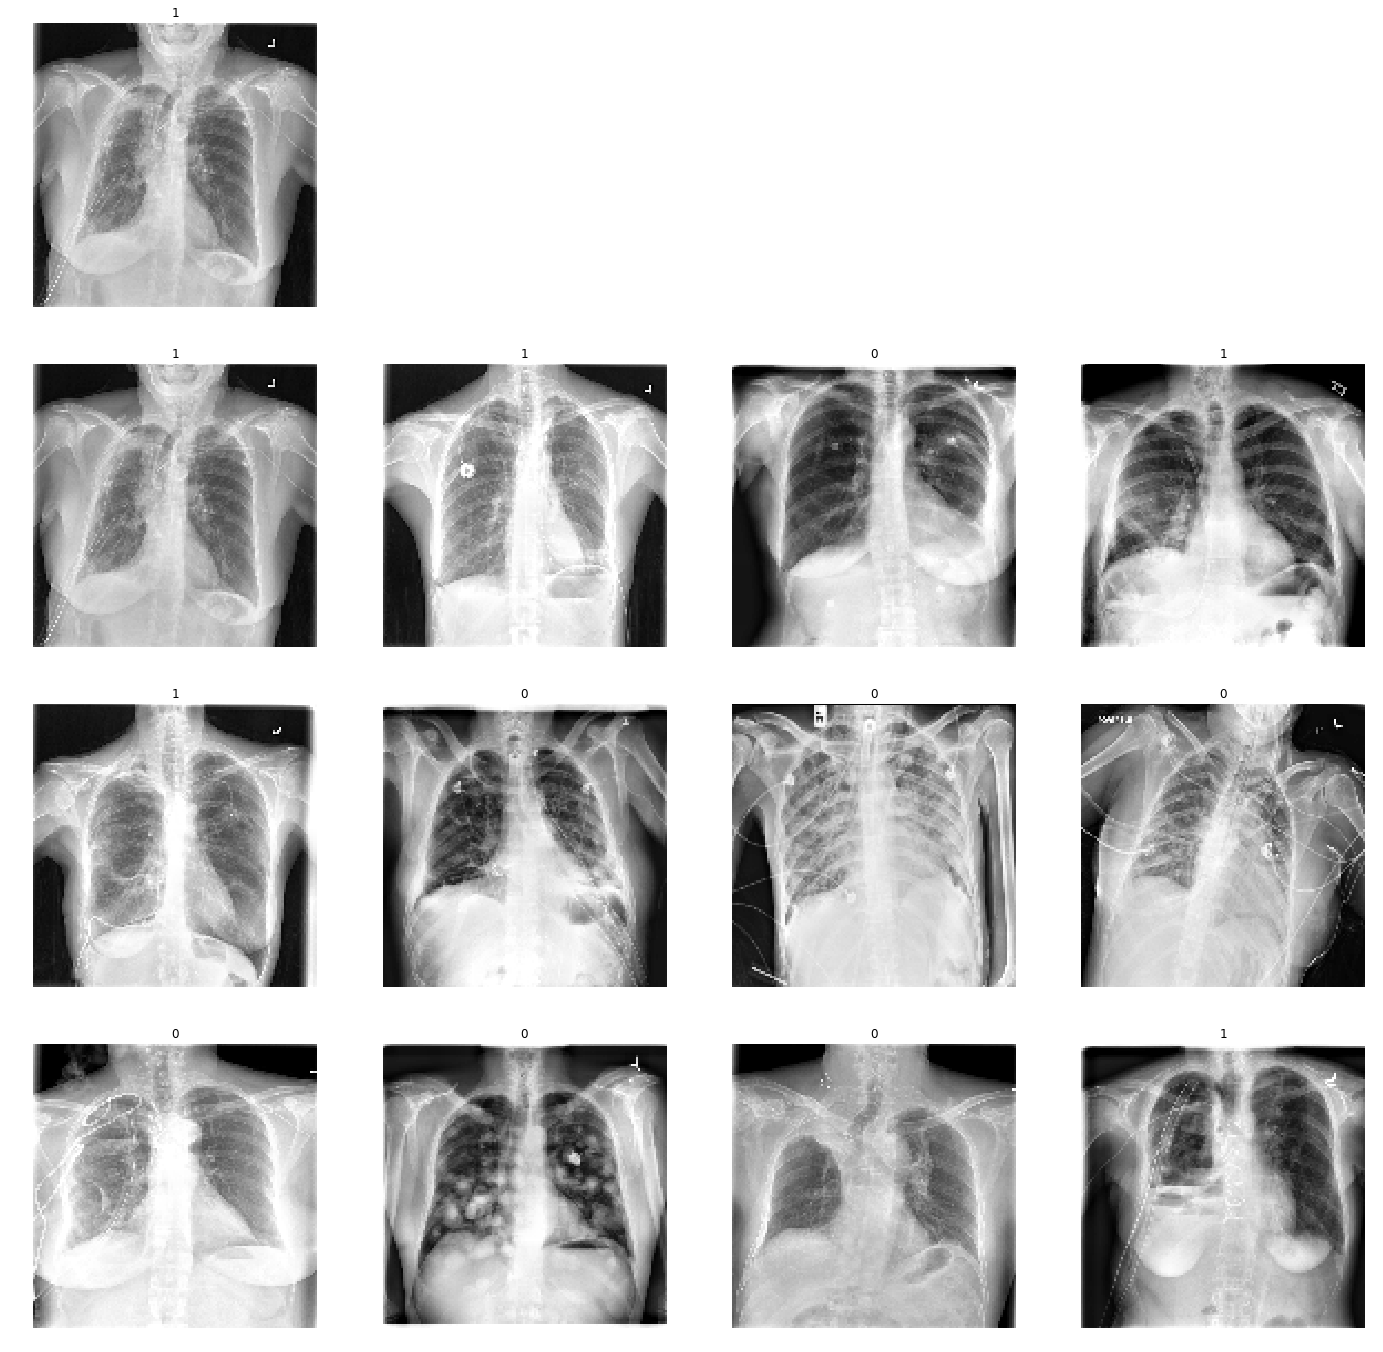

In [32]:
display_closest(index, 5, new_files, new_image_features)

In [33]:
siam_learner.save('siam_leaner_pneumothorax_128_resnet50')